# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

## Part A Question 1

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
shap.initjs()


import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42

os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [3]:
df = pd.read_csv('./full.csv') 
df.head()

filename       tempo  total_beats  average_beats  \
0  app_3001_4001_phnd_neg_0000.wav  184.570312          623      69.222222   
1  app_3001_4001_phnd_neg_0001.wav  151.999081          521      74.428571   
2  app_3001_4001_phnd_neg_0002.wav  112.347147         1614     146.727273   
3  app_3001_4001_phnd_neg_0003.wav  107.666016         2060     158.461538   
4  app_3001_4001_phnd_neg_0004.wav   75.999540           66      33.000000   

   chroma_stft_mean  chroma_stft_var  chroma_cq_mean  chroma_cq_var  \
0          0.515281         0.093347        0.443441       0.082742   
1          0.487201         0.094461        0.542182       0.073359   
2          0.444244         0.099268        0.442014       0.083224   
3          0.454156         0.100834        0.424370       0.084435   
4          0.478780         0.100000        0.414859       0.089313   

   chroma_cens_mean  chroma_cens_var  ...  mfcc15_mean  mfcc15_var  \
0          0.249143         0.021261  ...   -10.669799   63.340282   
1          0.274423         0.008025  ...    -5.666375   90.256195   
2          0.264430         0.013410  ...    -5.502390   73.079750   
3          0.257672         0.016938  ...    -8.812989   93.791893   
4          0.252143         0.019757  ...    -6.584204   64.973305   

   mfcc16_mean  mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0     1.811605   58.117188    -3.286546   54.268448    -2.719069   59.548176   
1     1.573594  105.070496    -0.742024   82.417496    -1.961745  119.312355   
2     0.202623   72.040550    -4.021009   73.844353    -5.916223  103.834824   
3    -0.429413   60.002579    -4.013513   82.544540    -5.858006   84.402092   
4     0.744403   68.908516    -6.354805   66.414391    -6.555534   47.852840   

   mfcc19_mean  mfcc19_var  
0    -4.559987   70.774803  
1     1.513660  101.014572  
2    -2.939086  113.598824  
3     0.686969   90.126389  
4    -4.809713   73.033966  

[5 rows x 78 columns]

In [4]:
df['label'] = df['filename'].str.split('_').str[-2]

In [5]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [6]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [7]:
features = []
for i in X_train.columns[0:]:
    features.append(i)

## Question 1A

In [8]:
num_neurons = 128
learning_rate = 0.001
batch_size = 256
no_epochs = 100

In [9]:
model = Sequential([Dense(num_neurons, activation='relu'),
                    Dropout(0.2), Dense(num_neurons, activation ='relu'),
                    Dropout(0.2), Dense(num_neurons, activation='relu'),
                    Dropout(0.2), Dense(1, activation='sigmoid')])


In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
model.compile(loss= 'binary_crossentropy', optimizer = "adam", metrics= ['accuracy']) # Default learning rate for adam algo is 0.001

In [11]:
history = {}
history['model'] = model.fit(X_train_scaled, y_train,
                            epochs = no_epochs, verbose = 1,
                            batch_size = batch_size, validation_data = (X_test_scaled, y_test), callbacks = [callback])

Epoch 1/100
499/499 [==============================] - 4s 4ms/step - loss: 0.6896 - accuracy: 0.5364 - val_loss: 0.6847 - val_accuracy: 0.5521
Epoch 2/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6834 - accuracy: 0.5531 - val_loss: 0.6817 - val_accuracy: 0.5558
Epoch 3/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6800 - accuracy: 0.5608 - val_loss: 0.6800 - val_accuracy: 0.5609
Epoch 4/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6772 - accuracy: 0.5658 - val_loss: 0.6765 - val_accuracy: 0.5676
Epoch 5/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6740 - accuracy: 0.5731 - val_loss: 0.6734 - val_accuracy: 0.5745
Epoch 6/100
499/499 [==============================] - 2s 5ms/step - loss: 0.6704 - accuracy: 0.5791 - val_loss: 0.6707 - val_accuracy: 0.5783
Epoch 7/100
499/499 [==============================] - 2s 4ms/step - loss: 0.6661 - accuracy: 0.5870 - val_loss: 0.6676 - val_accuracy: 0.5868

#### Plot of train and test accuracies training epochs

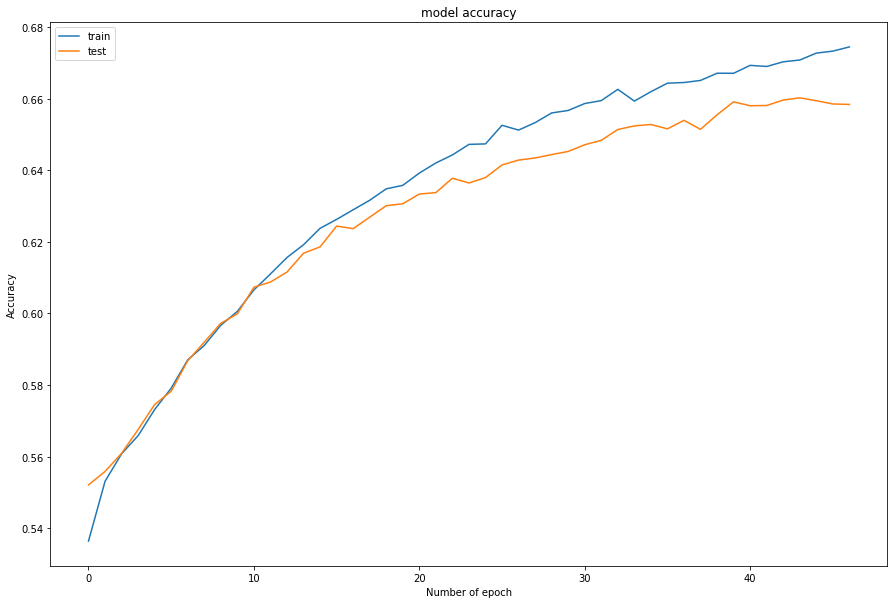

In [12]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(history['model'].history['accuracy'])
plt.plot(history['model'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Plot of train and test loss training epochs

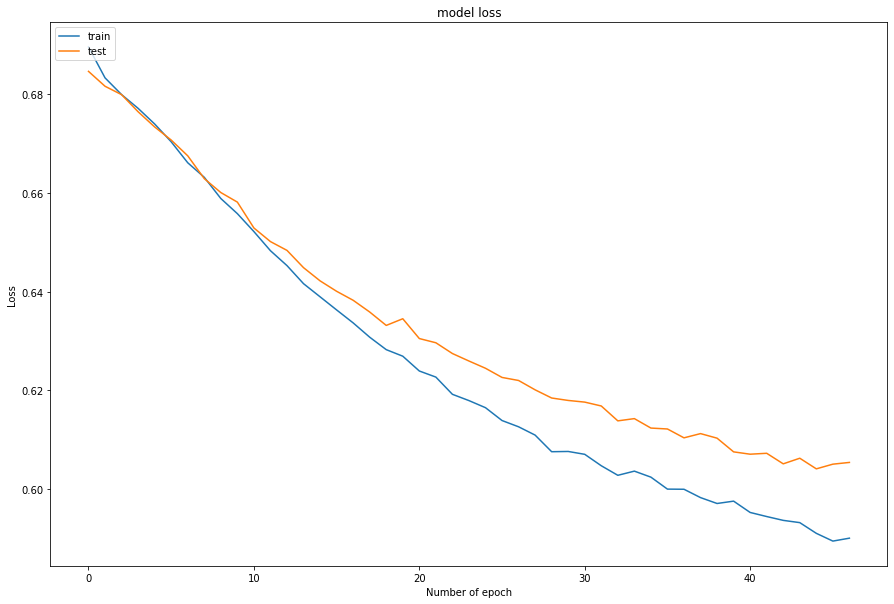

In [13]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(history['model'].history['loss'])
plt.plot(history['model'].history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Question 1B

#### Comments on the line plots

**Both training and validation accuracies of the model is increasing at a decreasing rate. Initially as the model trains, both train and test accuracy of the model rises sharply. Soon, its growth would decrease and eventually reach a plateau.**

**If there was no early-stopping mechanism, the model might overfit which would compromise on the model's accuracy.**

**Both training and validation loss are decreasing until reaches the minimum. Loss indicates the error or "how bad" the predictions are against the targeted value. We used binary cross entropy as it compares each of the predicated probabilities to the actual class output which can be either 0 or 1. As such, we aim to minimize loss as it indicates robustness of the model.**



#### Why early stopping is used?

**Early stopping is required to reduce overfitting without compromising on model accuracy. With the early stopping technique, the model will stop training before it starts to overfit which leads to increase in error and a drop in model's accuracy. With patience of 3, the training would be stopped when validation accuracy do not improve after 3 epoch.** 
